# Certification and Training using Interval Bound Propagation

In this notebook we will look at using interval bound propagation (IBP) to assess a neural network's certified robustness. 

To do so we will use a datapoint's interval, also called box, representation. This captures the minimum and maximum values that a feature can take. 

Then we propagate the interval through the neural network and, by using interval arithmetic on the neural network components we can determine if a datapoint could have its class changed. 

The interval domain has the great advantage that it is *fast*. However, this speed comes at the expense of precision - we aggressively over-approximate in the forward pass and so we can often only certify a small subset of the data which is safe. More formally, this technique is sound but incomplete.

We can see an example of how imprecision arises by looking at a neural network layer that causes a rotation: 

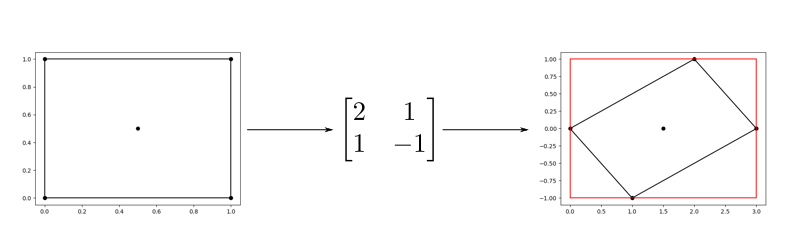

The exact operation when multiplied with the weight matrix should lead to the rotated rectangle. However, in the interval domain we only consider the maximums and minimums of each feature, thus resulting in the larger red rectangle which contains many excess regions.

Let's see how this does in practice!

In [1]:
import torch
import torch.optim as optim
import numpy as np

from torch import nn
from sklearn.utils import shuffle

from art.estimators.certification import interval
from art.utils import load_mnist, preprocess, to_categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device ', device)

bound = 0.05

Using device  cuda:0


In [2]:
# We make an example pytorch classifier

class MNISTModel(torch.nn.Module):
    """
    The base model which we will then convert into a certified classifer.
    """

    def __init__(self, number_of_classes: int):
        super(MNISTModel, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=16,
                                      kernel_size=4,
                                      stride=2)

        self.conv_2 = torch.nn.Conv2d(in_channels=16,
                                      out_channels=32,
                                      kernel_size=4,
                                      stride=1)

        self.fc1 = torch.nn.Linear(in_features=3200, out_features=number_of_classes)

        self.relu = torch.nn.ReLU()

    def forward(self, x: "torch.Tensor") -> "torch.Tensor":
        """
        Computes the forward pass though the neural network
        :param x: input data of shape (batch size, N features)
        :return: model prediction
        """
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = torch.flatten(x, 1)
        return self.fc1(x)


In [3]:
# Setup the MNIST Model

model = MNISTModel(number_of_classes=10)
model.to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [4]:
# Get the MNIST data

(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

x_test = np.squeeze(x_test)
x_test = np.expand_dims(x_test, axis=1)
y_test = np.argmax(y_test, axis=1)

x_train = np.squeeze(x_train)
x_train = np.expand_dims(x_train, axis=1)
y_train = np.argmax(y_train, axis=1)

In [5]:
# Train the model normally

def standard_train(model, opt, criterion, x, y, bsize=32, epochs=5):
    num_of_batches = int(len(x) / bsize)
    for epoch in range(epochs):
        x, y = shuffle(x, y)
        loss_list = []
        for bnum in range(num_of_batches):
            x_batch = np.copy(x[bnum * bsize:(bnum + 1) * bsize])
            y_batch = np.copy(y[bnum * bsize:(bnum + 1) * bsize])

            x_batch = torch.from_numpy(x_batch).float().to(device)
            y_batch = torch.from_numpy(y_batch).type(torch.LongTensor).to(device)

            # zero the parameter gradients
            opt.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss_list.append(loss.data.cpu())
            loss.backward()
            opt.step()
        print('End of epoch {} loss {}'.format(epoch, np.mean(loss_list)))
    return model

model = standard_train(model=model,
                       opt=opt,
                       criterion=criterion,
                       x=x_train,
                       y=y_train)

End of epoch 0 loss 0.4864298701286316
End of epoch 1 loss 0.2043914496898651
End of epoch 2 loss 0.12787242233753204
End of epoch 3 loss 0.09274934977293015
End of epoch 4 loss 0.0746498852968216


In [6]:
# Lets now get the predicions for the MNIST test set and see how well our model is doing.
with torch.no_grad():
    test_preds = model(torch.from_numpy(x_test).float().to(device))

test_preds = np.argmax(test_preds.cpu().detach().numpy(), axis=1)
print('Test acc: ', np.mean(test_preds == y_test) * 100)

Test acc:  97.96000000000001


In [7]:
# But how robust are these predictions? 
# We can now examine this neural network's certified robustness. 
# We pass it into PyTorchIBPClassifier. We will get a print out showing which 
# neural network layers have been registered. There will also be a 
# warning to tell us that PytorchInterval currently infers a reshape when 
# a neural network goes from using convolutional to dense layers. 
# This will cover the majority of use cases, however, if not then the 
# certification layers in art.estimators.certification.interval.interval.py 
# can be used to directly build a certified model structure.

interval_classifier = interval.PyTorchIBPClassifier(model=model, 
                                                    clip_values=(0, 1), 
                                                    loss=nn.CrossEntropyLoss(), 
                                                    input_shape=(1, 28, 28), 
                                                    nb_classes=10)

Inferred reshape on op num 4


In [8]:
# Regular accuracy on normal data
with torch.no_grad():
    test_preds = model(torch.from_numpy(x_test).float().to(device))

test_preds = np.argmax(test_preds.cpu().detach().numpy(), axis=1)
print('Test acc: ', np.mean(test_preds == y_test))

Test acc:  0.9796


In [9]:
# Now to get the certified performance. 

# Here we will manually convert the data into its interval representation
# upper_bounds represents the maximum any feature could take given the bound and the pixel limits
# lower_bounds represents the minium any feature could take given the bound and the pixel limits
upper_bounds = np.clip(np.expand_dims(x_test, axis=1) + bound, 0, 1)
lower_bounds = np.clip(np.expand_dims(x_test, axis=1) - bound, 0, 1)

# We stack this to make a representation of the data defined by its upper and lower bounds
interval_x = np.concatenate([lower_bounds, upper_bounds], axis=1)

with torch.no_grad():
    interval_preds = interval_classifier.predict_intervals(x=interval_x,
                                                      is_interval=True,
                                                      batch_size=32)
    cert_results = interval_classifier.certify(preds=interval_preds, labels=y_test)
    print('Certified score ', np.mean(cert_results))

Certified score  0.0


In [10]:
# We can also have a closer look at what the predict_intervals method returns. 
# Lets examine the last batch of predictions we obtained.
# It is of shape (batch_size, 2, featues) 
# The axis 2 represents the lower and upper bound predictions for the datapoint.
# We can print some of them out to manually see:

for i, pred in enumerate(interval_preds[0:5]):
    print(f'For sample {i}:')
    for cnum, (class_pred_lower, class_pred_higher) in enumerate(zip(pred[0], pred[1])):
        print(f'The lower bound pred: {class_pred_lower} and upper pred: {class_pred_higher}')
    print('------------------------------------------')

# Note that intervals for different classes overlap substantially.
# For a sample to be certified correct, a class's lower bound prediction must be higher than 
# all other class's upper bound. In that way there is no perturbation in the input that could 
# cause the correct class to have a final precition smaller than an incorrect class.

For sample 0:
The lower bound pred: -35.76298141479492 and upper pred: 18.96987533569336
The lower bound pred: -45.13648223876953 and upper pred: 17.85682487487793
The lower bound pred: -29.591373443603516 and upper pred: 26.661205291748047
The lower bound pred: -28.94809341430664 and upper pred: 26.747478485107422
The lower bound pred: -47.43501281738281 and upper pred: 14.983299255371094
The lower bound pred: -35.376808166503906 and upper pred: 24.173919677734375
The lower bound pred: -56.462249755859375 and upper pred: 8.382795333862305
The lower bound pred: -25.337738037109375 and upper pred: 31.648338317871094
The lower bound pred: -35.181827545166016 and upper pred: 19.416484832763672
The lower bound pred: -36.235626220703125 and upper pred: 23.697036743164062
------------------------------------------
For sample 1:
The lower bound pred: -30.613969802856445 and upper pred: 18.29610252380371
The lower bound pred: -32.045406341552734 and upper pred: 24.777889251708984
The lower bou

We can see that the certified performance is very low! Much lower than the certification you could get with using Zonotopes for example (see the deepz notebook for comparison). So why use intervals?

- Computationally it is very fast: only x2 overhead compared to normal classification as each datapoint is represented by upper and lower bounds. 
- By comparison Zonotopes can grow (particularly in terms of memory) hundreds of times larger. 
- We can improve the performance by orders of magnitude if we combine it with methods like certified adversarial training.

None the less, we can use the interval domain to certify for smaller regions of inputs.

We can compare against the empirical results with PGD

In [11]:
from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier

interval_classifier.model.set_forward_mode("attack")
attack = ProjectedGradientDescent(
    estimator=interval_classifier,
    eps=bound,
    eps_step=0.001,
    max_iter=20,
    num_random_init=1,
)

i_batch = attack.generate(x_test.astype('float32'), y_test.astype('float32'))
adv_preds = interval_classifier.predict(i_batch)
adv_preds = np.argmax(adv_preds, axis=1)
print('Test acc: ', np.mean(adv_preds == y_test) * 100)

PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Test acc:  94.66


## Training with IBP

Now lets look at the effects of training with certification and we will be able to see orders of magnitude improvement on the certified performance!

In [12]:
from torch.optim.lr_scheduler import MultiStepLR
from art.defences.trainer import AdversarialTrainerCertifiedIBPPyTorch

# Starting from a fresh model

model = MNISTModel(number_of_classes=10)
model.to(device)
criterion = nn.CrossEntropyLoss()


interval_classifier = interval.PyTorchIBPClassifier(model=model, 
                                                    clip_values=(0, 1), 
                                                    loss=nn.CrossEntropyLoss(), 
                                                    input_shape=(1, 28, 28),
                                                    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
                                                    nb_classes=10)


# Uncomment if you wish to train your own model, but can take around 90 min with a GPU.

# scheduler = MultiStepLR(interval_model._optimizer, milestones=[50, 80], gamma=0.1)
# trainer = AdversarialTrainerCertifiedIBPPyTorch(classifier=interval_model, bound=0.4,)
# trainer.fit(x=x_train, y=y_train, scheduler=scheduler, batch_size=100, nb_epochs=200, limits=[0, 1])
# torch.save(trainer._classifier.model.state_dict(), 'notebook_models/mnist/certified/certified_ibp_model.pt')

# Here we will load a model which was trained using the above function.
interval_classifier.model.load_state_dict(torch.load('notebook_models/mnist/certified/certified_ibp_model.pt', 
                                                map_location=torch.device(device)))
interval_classifier.model.re_convert() # this is needed because the dense equivalent layer has the initial random values


Inferred reshape on op num 4


In [13]:
# Get the clean accuracy using the trained interval_classifier

# as we are working with normal data, and just want clean performance, we set the forward mode to concrete
interval_classifier.model.set_forward_mode("concrete")
preds = interval_classifier.model.forward(x=x_test)

clean_acc = interval_classifier.get_accuracy(preds, y_test)
print(f'The clean acc is {clean_acc}')

The clean acc is 0.9617


In [14]:
# Empirical PGD accuracy

# We are interfacing the classifier with one of the ART attacks, 
# So we need to set the forward mode to attack.

interval_classifier.model.set_forward_mode("attack")
attack = ProjectedGradientDescent(
    estimator=interval_classifier,
    eps=0.4,
    eps_step=0.01,
    max_iter=30,
    num_random_init=1,
)

i_batch = attack.generate(x_test.astype('float32'), y_test.astype('float32'))
adv_preds = interval_classifier.predict(i_batch)

print(f'Adv acc: {np.mean(np.argmax(adv_preds, axis=1) == y_test) * 100}')

PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Adv acc: 92.2


In [15]:
# Certified Accuracy

# To get the certified accuracy we set the forward mode to abstract
interval_classifier.model.set_forward_mode("abstract")
interval_preds = interval_classifier.predict_intervals(x=x_test,
                                                  bounds=0.4,
                                                  limits=[0.0, 1.0])

samples_certified = interval_classifier.certify(preds=interval_preds, labels=y_test)
print(f'Certified acc {np.sum(samples_certified) / len(y_test)}')

Certified acc 0.7509


In [16]:
# We can also convince ourselves that the upper and lower bounds contain the 
# predictions for the adversarial data by having a look at some of the predictions. 
# Lets do so for the first 10 samples

for i, (adv_pred, cert_pred) in enumerate(zip(adv_preds[0:5], interval_preds[0:5])):
    print(f'For sample {i}:')
    for cnum, (adv_p, class_pred_lower, class_pred_higher) in enumerate(zip(adv_pred, pred[0], pred[1])):
        print(f'The lower bound pred: {class_pred_lower} and upper pred: {class_pred_higher} adv sample pred: {adv_p}')
    print('------------------------------------------')

For sample 0:
The lower bound pred: -36.567726135253906 and upper pred: 15.803500175476074 adv sample pred: -13.662408828735352
The lower bound pred: -42.30445861816406 and upper pred: 20.1270751953125 adv sample pred: -10.511754989624023
The lower bound pred: -32.78966522216797 and upper pred: 20.093400955200195 adv sample pred: -4.524026393890381
The lower bound pred: -36.702457427978516 and upper pred: 19.05740737915039 adv sample pred: -0.1533353626728058
The lower bound pred: -27.400218963623047 and upper pred: 29.82215118408203 adv sample pred: -9.642894744873047
The lower bound pred: -38.59861755371094 and upper pred: 20.023099899291992 adv sample pred: -5.101047515869141
The lower bound pred: -36.92227554321289 and upper pred: 20.892738342285156 adv sample pred: -20.015060424804688
The lower bound pred: -32.97300720214844 and upper pred: 22.323326110839844 adv sample pred: 6.100724697113037
The lower bound pred: -31.611032485961914 and upper pred: 21.05921745300293 adv sample p

## Analysis

We can see that the certified accuracy is very high, with the trained model reaching 75%

Also, note the difference between the empirical adversarial accuracy and the certified accuray. 
The empirical adversarial accuracy is higher (92% in this case) and the gap with the certified accuracy shows that
there could be several adversarial examples that exist which PGD was not able to find. 

Note! That IBP overapproxaimates the impact of aritmetic operations on the inputs, and will give us a more pessimistic view on robustness than the model is likely capable of, but it gives us two important peicies of information: 

+ The certified performance with IBP of the model is a lower bound on the performnace. Thus there may be some datapoints that IBP says *could* be misclassified, but in fact cannot be.

+ If IBP says a datapoint cannot be misclassified then we can be absolutly certain that the model is robust to the given input and allowable perturbation.

The true performance of the model therefore will lie somewhere between the certified and empircial robustness.